#Reconhecimento de Digitos escritos a Mão - Digit Recognizer

Este Notebook tem a função de Resolver a competição do  <a href= https://www.kaggle.com/c/digit-recognizer> Kaggle </a> para um problema classico de visão computacional por meio de Redes Densas. 

##Entendendo o Problema 

Imagine que nosso Objetivo seja criar uma rede rede neural para reconhecimento de digitos escritos a mão, ou seja a rede tem que ser capaz de receber uma foto (28x28 pixels) e dizer qual digito ali está escrito.

![Exemplo de Digito escrito a mão](https://github.com/GabrielLima1995/Digit-Recognizer/blob/master/Digit1.png?raw=true)

##Preparando o Ambiente Colab

Para iniciarmos, vamos ativar nossa GPU no google colab afim de se obter um treino em um menor período de tempo.

Para tal ação precisamos então clicar em ambiente de execução > Alterar o Tipo de Ambiente de Execução > Acelerador de Hardware > GPU .

![texto alternativo](https://github.com/GabrielLima1995/Digit-Recognizer/blob/master/gpu_activate_colab.png?raw=true)



Para verificarmos se nossa Gpu esta ativada fazemos :

In [1]:
!nvidia-smi

Sun Aug  2 17:29:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Veremos agora o que há no diretório da maquina que o google emprestou. Lembrando que o período de armazenamento é de 12h. 

In [2]:
!ls 

sample_data


Baixaremos então o Dataset do Kaggle, onde o mesmo hospedei também no Github. 

In [3]:
!wget -O - https://github.com/GabrielLima1995/Digit-Recognizer/archive/master.tar.gz | tar xz --strip=2 "Digit-Recognizer-master/data"

--2020-08-02 17:29:59--  https://github.com/GabrielLima1995/Digit-Recognizer/archive/master.tar.gz
Resolving github.com (github.com)... 13.229.188.59
Connecting to github.com (github.com)|13.229.188.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/GabrielLima1995/Digit-Recognizer/tar.gz/master [following]
--2020-08-02 17:29:59--  https://codeload.github.com/GabrielLima1995/Digit-Recognizer/tar.gz/master
Resolving codeload.github.com (codeload.github.com)... 54.251.140.56
Connecting to codeload.github.com (codeload.github.com)|54.251.140.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘STDOUT’

-                       [             <=>    ]  15.01M  3.37MB/s    in 4.6s    

2020-08-02 17:30:04 (3.25 MB/s) - written to stdout [15744736]



Uma vez Baixado, basta garantirmos que os arquivos se encontram no local correto. 

In [4]:
!ls

sample_data  sample_submission.csv  test.csv  train.csv


##Importando as bibliotecas

Importaremos então todas as Bibliotecas que iremos usar. Se você não está Familiarizado com alguma não se preocupe, pois comentarei ao longo deste notebook.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models 
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

##Preparando e Entendendo os Dados 

Nesta Parte iremos Entender nossos dados para que possamos tratá-los da melhor maneira, sendo assim o primeiro passo é a importação e a visualização.


Usaremos a biblioteca Pandas para tal procedimento, sendo assim os dados denominados train.csv estarão dentro de dataframe. 

In [7]:
dataframe = pd.read_csv("train.csv",sep=",")

Para visualizar o dataframe iremos usar o método head(), no qual o mesmo mostra apenas as 5 primeiras linhas de nossa tabela por default.

In [8]:
dataframe.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Usaremos também o método shape para análisarmos a dimensão dessa tabela.

In [9]:
dataframe.shape

(42000, 785)

É importante saber com que tipo de dados estamos lidando, sendo assim precisamos entender o que essa tabela significa. 

Voltando para o site do problema em questão vemos uma <a href= https://www.kaggle.com/c/digit-recognizer/data >breve explicação dos dados </a> no qual irei explainar para vocês. 

Como já sabemos nossa Imagem possui uma resolução de 28 x 28 pixels totalizando então 784 pixels, onde cada elemento é a descrição dos valores de cada pixel da imagem, onde cada pixel assume um valor inteiro ente 0 e 255 no qual os valores mais altos representam tons mais escuros... 
Mas então porque a tabela está com uma dimensão de 42000 x 785 ? 

Primeiro precisamos ter em mente que para treinar nossa rede necessitamos de inumeros exemplos (neste caso 42000) e análisando a descrição do problema temos que cada linha representa 1 imagem achatada totalizando 784 colunas. 

![](https://github.com/GabrielLima1995/Digit-Recognizer/blob/master/flat_image.png?raw=true)


Por fim foi adicionado em cada linha uma coluna, sendo esta o label, ou seja um valor de 0 á 9 dizendo qual algarismo essa imagem representa. 

Transformaremos esse dataframe em um numpy array para que possamos realizar operações matemáticas com o mesmo.

In [10]:
train = dataframe.values
print(type(train))
print(train)
print(train.shape)

<class 'numpy.ndarray'>
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [7 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 [9 0 0 ... 0 0 0]]
(42000, 785)


Separaremos então os labels dos pixels.

In [11]:
y_labels = train[:,0]
print(y_labels)
print(y_labels.shape)

[1 0 1 ... 7 6 9]
(42000,)


In [12]:
digits_flattened = train[:,1:]
print(digits_flattened)
print(digits_flattened.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(42000, 784)


Para que possamos plotar as imagens precisamos trazer os pixels para a forma matricial, para tal utilizaremos o método reshape().

In [13]:
digits = digits_flattened.reshape(digits_flattened.shape[0],28,28)
print(digits.shape)

(42000, 28, 28)


Para plotar a imagem utilizaremos o matplotlib. 

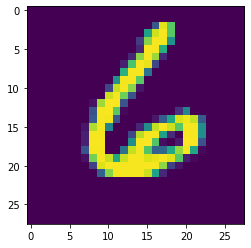

In [14]:
plt.imshow(digits[-2])

Nos foi fornecido tambem o conjunto de teste, sendo este com 28000 imagens sem labels, pois a submissão no Kaggle será realizada com essas respostas. 

Conforme Realizado anteriormente importaremos então esses dados. 

In [15]:
dataframe_test = pd.read_csv("test.csv",sep=",")

Converteremos eles para um numpy array e assim que a rede já tiver sido projetada faremos uma forward propagation para a obtenção de suas respostas. 

In [16]:
test_flattened = dataframe_test.values

In [17]:
print(type(test_flattened))
print(test_flattened)
print(test_flattened.shape)

<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(28000, 784)


Como não temos um conjunto para validação, precisaremos então separar uma parte do nosso conjunto de treino para esse proposito. 
Usaremos a função train_test_split do Sklearn para separarmos o dataset em 30% validação e 70% treino. 

In [18]:
X_train, X_val, y_train, y_val = train_test_split(digits_flattened, y_labels, test_size=0.33, random_state=42)

Após a separação temos:

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(28140, 784)
(28140,)
(13860, 784)
(13860,)


Por fim realizaremos one hot encoded com os labels, passando os mesmos para a forma categórica.

In [20]:
y_train_encoded = to_categorical(y_train)
y_val_encoded   = to_categorical(y_val)

In [21]:
print(y_train_encoded.shape)
print(y_val_encoded.shape)

(28140, 10)
(13860, 10)


##Rede Densa 

<p>Aqui iniciaremos a fase de criação da rede neural, onde foi escolhido as redes densas para a resolução desse problema. </p>
<p>Obs: A resolução com Redes Neurais Convolucionais será abordada em outro notebook. </p>

A Rede neural escolhida possui 2 Hidden Layers de 64 neurônios cada e 10 neurônios na camada de saída. 
Foi adicionado Dropout nas camadas intermediárias, onde seu principal objetivo é eliminar o overfitting. 

In [24]:
model = models.Sequential()
model.add(layers.Dense(units=64,activation='relu',input_shape=(784,), kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(units=64,activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(units=10,activation='softmax'))

Uma vez que a rede foi criada, utilizaremos o método summary() para a análise da mesma. 

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


Para treinar utilizaremos o gradiente com momento e a métrica de análise escolhida é acurácia.

In [26]:
mom = optimizers.SGD(lr = 0.001,decay=0,momentum=0.9,nesterov=True)
model.compile(optimizer=mom,loss='categorical_crossentropy',metrics=['accuracy'])

Treinaremos então a rede com 600 épocas com um batch size de 120 lotes, onde todo o histórico desse treino é guardado na variável history. 

In [27]:
history = model.fit(X_train,y_train_encoded,batch_size=120,epochs=600,verbose=1,validation_data=(X_val,y_val_encoded))

Epoch 1/600
235/235 [==============================] - 1s 5ms/step - loss: 6.9823 - accuracy: 0.2880 - val_loss: 4.2989 - val_accuracy: 0.3310
Epoch 2/600
235/235 [==============================] - 1s 4ms/step - loss: 4.1215 - accuracy: 0.3401 - val_loss: 3.9848 - val_accuracy: 0.3472
Epoch 3/600
235/235 [==============================] - 1s 4ms/step - loss: 3.8224 - accuracy: 0.3639 - val_loss: 3.6894 - val_accuracy: 0.3799
Epoch 4/600
235/235 [==============================] - 1s 4ms/step - loss: 3.5062 - accuracy: 0.4211 - val_loss: 3.3910 - val_accuracy: 0.4312
Epoch 5/600
235/235 [==============================] - 1s 4ms/step - loss: 3.2262 - accuracy: 0.4598 - val_loss: 3.0941 - val_accuracy: 0.4835
Epoch 6/600
235/235 [==============================] - 1s 4ms/step - loss: 2.9570 - accuracy: 0.4923 - val_loss: 2.8500 - val_accuracy: 0.4948
Epoch 7/600
235/235 [==============================] - 1s 4ms/step - loss: 2.7347 - accuracy: 0.5166 - val_loss: 2.6467 - val_accuracy: 0.5061

Para análisarmos como foi o treinamento fazemos:

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
train_loss = history_dict['loss']
val_loss   = history_dict['val_loss']

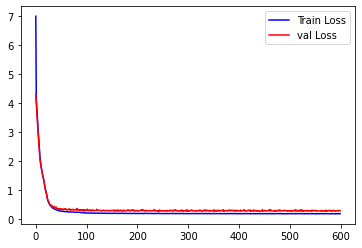

In [30]:
plt.plot(train_loss,'b',label="Train Loss")
plt.plot(val_loss,'r',label="val Loss")
plt.legend()
plt.show()

In [31]:
train_acc = history_dict['accuracy']
val_acc   = history_dict['val_accuracy']

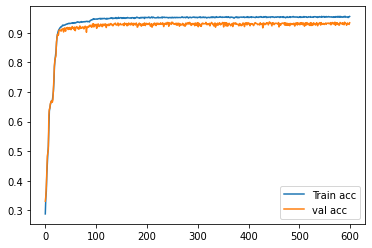

In [32]:
plt.plot(train_acc,label="Train acc")
plt.plot(val_acc,label="val acc")
plt.legend()
plt.show()

Vemos que o resultado do treino foi em torno de 93% a 95% de acurácia no conjunto de validação, tendo espaço para melhorias, onde pretendemos atingir um melhor resultado usando uma rede neural convolucional. 

Por fim para obtermos os resultados do conjunto de teste fazemos:

In [33]:
results = model.predict(test_flattened)

In [34]:
print(results)
print(results.shape)

[[2.92130729e-11 1.46506196e-10 9.99921799e-01 ... 2.57043553e-06
  1.25443389e-08 4.08844813e-14]
 [9.99793589e-01 2.20870630e-16 5.57134115e-07 ... 2.61535365e-06
  7.05431286e-12 2.10195662e-06]
 [2.71209865e-06 2.94027675e-04 6.87815918e-05 ... 1.88269885e-03
  6.55113533e-03 9.83107209e-01]
 ...
 [7.17796455e-14 7.27994465e-09 4.65875516e-09 ... 1.05667759e-07
  6.27594432e-07 9.71515619e-05]
 [6.83104099e-06 2.23142033e-05 1.93072465e-05 ... 6.71951380e-03
  1.07442924e-04 9.63278532e-01]
 [1.55468693e-10 2.02405892e-09 9.99709070e-01 ... 3.38847667e-06
  1.17636027e-07 2.52893247e-13]]
(28000, 10)


In [35]:
y_results = results.argmax(axis=1)

In [36]:
print(y_results)
print(y_results.shape)

[2 0 9 ... 3 9 2]
(28000,)


In [37]:
p = np.array(list(range(1,len(y_results)+1)))

In [39]:
submition = pd.DataFrame({'ImageId':p,'Label':y_results})
submition.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,3


In [40]:
submition.to_csv('submition.csv',sep=',',index=False)

In [41]:
!ls

sample_data  sample_submission.csv  submition.csv  test.csv  train.csv
